In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns 
import matplotlib.pyplot as plt
from scipy.signal import welch

Cargamos los datos

In [3]:
eeg1 = pd.read_csv("participantes/eeg_pp_14.csv")

features1 = pd.read_csv("participantes/eeg_features_14.csv")

In [3]:
eeg1.head()

,latency,fp1,fp2,f7,f3,fz,f4,f8,t7,c3,cz,c4,t8,p7,p3,pz,p4,p8,o1,o2
0,0.00241,-3.125597,-1.997728,-4.283708,-1.410118,-0.531345,-1.221053,-3.559847,-6.814795,-5.198093,-0.246838,-4.023839,-3.915787,1.927741,0.519291,-7.899948,0.270950,-0.337013,17.34155,4.603929
1,0.00631,-0.708909,1.371271,-5.665444,0.907954,1.381021,0.820970,-2.891171,4.171859,-3.127226,0.525291,-4.324387,-8.521935,14.893560,9.144904,-10.594510,-9.961110,-6.636574,41.05544,6.930787
2,0.01022,2.665386,5.920817,-4.158869,4.372355,5.155095,3.625076,-0.355327,14.829990,0.304604,2.843654,-1.764032,-7.741126,18.951920,10.911180,-10.530430,-14.555510,-9.040809,38.57952,3.971644
3,0.01413,3.378954,6.494709,-1.052137,5.058226,6.258564,3.768967,1.004640,14.994500,1.462552,4.053962,1.027914,-4.590752,14.562380,7.705611,-8.523515,-12.621040,-7.386034,24.87483,0.826491
4,0.01803,1.486100,2.714190,0.788135,2.522907,3.512336,0.878232,0.081925,6.064212,0.122495,3.627746,1.911963,-3.184557,9.171122,5.164177,-6.859539,-9.126245,-5.020747,19.79660,1.173068


In [4]:
len(eeg1), len(features1)

(96768, 2330)

In [5]:
features1.isnull().sum()

epoch                               0
window                              0
n_samples                           0
Start_w                             0
End_w                               0
                                 ... 
ch19-Sigma-Attention             2330
ch19-Beta-EngagementIndex        2330
ch19-Beta-Attention              2330
ch19-LowGamma-EngagementIndex    2330
ch19-LowGamma-Attention          2330
Length: 1489, dtype: int64

In [6]:
features1['Trust'].value_counts(dropna=False)

Trust
5.0    1050
4.0     350
NaN     330
1.0     300
3.0     200
2.0     100
Name: count, dtype: int64

In [4]:
features1 = features1.dropna(subset=["Trust", "Binary_Trust"]).reset_index(drop=True)


Para llevar a cabo el análisis de la señal, hay que incorporar la columna "epoch" del dataset "features" al dataset con las señales EEG en crudo, para, más tarde, llevar a cabo la partición de los datos adecuada, se unirá esta columna según los valores de "Start_w" y "End_w" y considerando el valor de latencia de las señales. De esta manera, se obtendrá un dataset con las señales EEG en crudo, la epoch a la que pertenece, la latencia y el valor de Trust y Binary_Trust.

In [ ]:
def assign_epochs(eeg1, features1):
    eeg1 = eeg1.copy()
    eeg1["epoch"] = np.nan
    eeg1["Trust"] = np.nan
    eeg1["Binary_Trust"] = np.nan
    
    for _, row in features1.iterrows():
        mask = (eeg1["latency"] >= row["Start_w"]) & (eeg1["latency"] <= row["End_w"])
        eeg1.loc[mask, "epoch"] = row["epoch"]
        eeg1.loc[mask, "Trust"] = row["Trust"]
        eeg1.loc[mask, "Binary_Trust"] = row["Binary_Trust"]
    
    return eeg1

# Asignar etiquetas
eeg1 = assign_epochs(eeg1, features1)

# Ver cuántos valores se quedaron sin epoch
print("Sin epoch:", eeg1["epoch"].isna().sum(), "de un total de", len(eeg1))

# Ver distribución de etiquetas
print("\nDistribución Binary_Trust:")
print(eeg1["Binary_Trust"].value_counts(dropna=False))

print("\nDistribución Trust:")
print(eeg1["Trust"].value_counts(dropna=False))


C:\Users\crist\AppData\Local\Temp\ipykernel_36868\1576416167.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'high_trust' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  eeg1.loc[mask, "Binary_Trust"] = row["Binary_Trust"]


Sin epoch: 28455 de un total de 96768

Distribución Binary_Trust:
Binary_Trust
high_trust    47179
NaN           28455
low_trust     21134
Name: count, dtype: int64

Distribución Trust:
Trust
5.0    33765
NaN    28455
4.0    13414
1.0    10256
3.0     7325
2.0     3553
Name: count, dtype: int64


Podemos observar que nos queda un alto % de valores nulos, esto se debe a que el primer start_w comienza más tarde que el primer valor de latencia, y lo mismo para el último valor de end_w, termina antes que el último valor de latencia. Estos nulos pueden corresponder con valores erróneos en la colocación inicial del casco o al momento de acabar el experimento, por lo que optamos por eliminarlos.

In [ ]:
# Eliminar filas donde alguna de las columnas clave es NaN
eeg1 = eeg1.dropna(subset=['epoch', 'Trust', 'Binary_Trust']).reset_index(drop=True)

# Ver cuántos valores se quedaron sin epoch
print("Sin epoch:", eeg1["epoch"].isna().sum(), "de un total de", len(eeg1))

# Ver distribución de etiquetas
print("\nDistribución Binary_Trust:")
print(eeg1["Binary_Trust"].value_counts(dropna=False))

print("\nDistribución Trust:")
print(eeg1["Trust"].value_counts(dropna=False))


Sin epoch: 0 de un total de 68313

Distribución Binary_Trust:
Binary_Trust
high_trust    47179
low_trust     21134
Name: count, dtype: int64

Distribución Trust:
Trust
5.0    33765
4.0    13414
1.0    10256
3.0     7325
2.0     3553
Name: count, dtype: int64


C:\Users\crist\AppData\Local\Temp\ipykernel_36868\3394219416.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=eeg1['Binary_Trust'], palette='coolwarm')
c:\Users\crist\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\crist\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


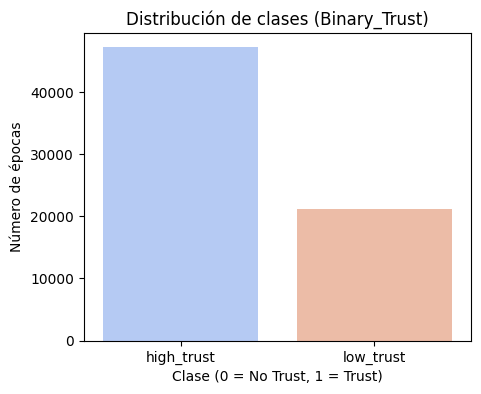

Distribución porcentual:
 Binary_Trust
high_trust    0.69063
low_trust     0.30937
Name: proportion, dtype: float64


In [ ]:
plt.figure(figsize=(5,4))
sns.countplot(x=eeg1['Binary_Trust'], palette='coolwarm')
plt.title("Distribución de clases (Binary_Trust)")
plt.xlabel("Clase (0 = No Trust, 1 = Trust)")
plt.ylabel("Número de épocas")
plt.show()

print("Distribución porcentual:\n", eeg1['Binary_Trust'].value_counts(normalize=True))

## Red Neuronal EEGNet

In [8]:
from braindecode import EEGClassifier
from braindecode.models import EEGNet
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, classification_report
from skorch.helper import predefined_split

In [12]:
fs = 1 / (eeg1['latency'].iloc[1] - eeg1['latency'].iloc[0])
print("Frecuencia de muestreo (Hz):", fs)

Frecuencia de muestreo (Hz): 255.75024390240998


### Focal Loss

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha, gamma, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        CE_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-CE_loss)
        F_loss = (1 - pt) ** self.gamma * CE_loss
        if self.reduction == 'mean':
            return F_loss.mean()
        elif self.reduction == 'sum':
            return F_loss.sum()
        else:
            return F_loss


### Trial Wise

Dividimos los datos de manera que no queden muestras mezcladas en los distintos conjuntos de entrenamiento, validación y test

In [ ]:
# Identificar todos los trials (epochs)
epochs = eeg1['epoch'].dropna().unique()

# Asociar cada trial a su etiqueta de confianza binaria
binary_trust_in_epoch = eeg1.groupby('epoch')['Binary_Trust'].first()

# Dividir trials en train, test y validación 
epochs_train, epochs_test = train_test_split(
    epochs,
    test_size=0.2,
    stratify=binary_trust_in_epoch.loc[epochs].values,
    random_state=42
)

# Dentro de train, split train/valid
epochs_train, epochs_valid = train_test_split(
    epochs_train,
    test_size=0.2,  
    stratify=binary_trust_in_epoch[epochs_train],
    random_state=42
)

df_train = eeg1[eeg1['epoch'].isin(epochs_train)].reset_index(drop=True)
df_valid = eeg1[eeg1['epoch'].isin(epochs_valid)].reset_index(drop=True)
df_test  = eeg1[eeg1['epoch'].isin(epochs_test)].reset_index(drop=True)

def make_trial_windows(df, window_size, stride):
    trials = df['epoch'].unique()
    X_list, y_list = [], []

    for trial in trials:
        trial_df = df[df['epoch']==trial].drop(columns=['latency','Trust','Binary_Trust','epoch'], errors='ignore')
        trial_signals = trial_df.values  
        label = df[df['epoch']==trial]['Binary_Trust'].iloc[0]
        label_bin = 0 if label=='low_trust' else 1

        # Extraer ventanas con stride
        for start in range(0, trial_signals.shape[0] - window_size + 1, stride):
            window = trial_signals[start:start+window_size, :]
            X_list.append(window.T)  
            y_list.append(label_bin)

    X_tensor = torch.tensor(X_list, dtype=torch.float32)
    y_tensor = torch.tensor(y_list, dtype=torch.long)

    return X_tensor, y_tensor

X_train_t, y_train_t = make_trial_windows(df_train, window_size=256, stride=32)
X_valid_t, y_valid_t = make_trial_windows(df_valid, window_size=256, stride=32)
X_test_t,  y_test_t  = make_trial_windows(df_test,  window_size=256, stride=32)

print(X_train_t.shape, y_train_t.shape)


torch.Size([584, 19, 256]) torch.Size([584])


### Selección de características

#### Métodos de filtro

In [ ]:
# === 2. Selección de canales (ANOVA) ===
from sklearn.feature_selection import f_classif
import numpy as np

# Convertimos a numpy y aplanamos por tiempo para tener una feature por canal
X_train_mean = X_train_t.mean(dim=2).numpy()
y_np = y_train_t.numpy()

# Calculamos F y p-values
F_values, pvals = f_classif(X_train_mean, y_np)

# Escogemos los canales con p<0.05 (significativos)
k = 10  
selected_channels = np.argsort(F_values)[-k:] 
print("Canales seleccionados:", selected_channels)


# Filtramos los tensores
X_train_t = X_train_t[:, selected_channels, :]
X_valid_t = X_valid_t[:, selected_channels, :]
X_test_t  = X_test_t[:, selected_channels, :]

print("Nueva forma de X_train:", X_train_t.shape)


Canales seleccionados: [ 0  3  4  1  5 18 12 17  6  2]
Nueva forma de X_train: torch.Size([584, 10, 256])


In [ ]:
from sklearn.feature_selection import mutual_info_classif

X_train_mean = X_train_t.mean(dim=2).numpy()
y_np = y_train_t.numpy()

# Mutual information
mi = mutual_info_classif(X_train_mean, y_np, random_state=42)
selected_channels = np.argsort(mi)[-10:]  

print("Canales seleccionados (MI):", selected_channels)

# Filtra los tensores
X_train_t = X_train_t[:, selected_channels, :]
X_valid_t = X_valid_t[:, selected_channels, :]
X_test_t  = X_test_t[:, selected_channels, :]
print("Nueva forma de X_train:", X_train_t.shape)

Canales seleccionados (MI): [ 1  6  3  5 17 11  4 14 12  2]
Nueva forma de X_train: torch.Size([584, 10, 256])


#### Método híbrido (filter+wrapper)

In [24]:
from sklearn.feature_selection import mutual_info_classif, SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression

X_mean = X_train_t.numpy().mean(axis=2)
mi = mutual_info_classif(X_mean, y_train_t.numpy(), random_state=42)
top_k = min(14, X_mean.shape[1])
top_channels = np.argsort(mi)[-top_k:]
X_filtered = X_mean[:, top_channels]

wrapper = SequentialFeatureSelector(
        LogisticRegression(max_iter=1000),
        n_features_to_select=min(10, top_k),
        direction='forward',
        n_jobs=-1
    )
wrapper.fit(X_filtered, y_train_t.numpy())
selected_channels = top_channels[wrapper.get_support()]
X_train_t = X_train_t[:, selected_channels, :]
X_valid_t = X_valid_t[:, selected_channels, :]
X_test_t  = X_test_t[:, selected_channels, :]
print("Canales finales (híbrido):", selected_channels)


Canales finales (híbrido): [10 13  1  6 17 11  4 14 12  2]


### Normalización de los datos

In [80]:
mean = X_train_t.mean(dim=(0,2), keepdim=True) 
std  = X_train_t.std(dim=(0,2), keepdim=True)
X_train_t = (X_train_t - mean) / (std + 1e-8)
X_valid_t = (X_valid_t - mean) / (std + 1e-8)
X_test_t  = (X_test_t - mean) / (std + 1e-8)


In [16]:
overlap = set(epochs_train).intersection(set(epochs_test))
print("Épocas repetidas en train y test:", overlap)

Épocas repetidas en train y test: set()


In [17]:
print("Train windows:", X_train_t.shape[0])
print("Valid windows:", X_valid_t.shape[0])
print("Test windows:",  X_test_t.shape[0])


Train windows: 584
Valid windows: 169
Test windows: 182


### Oversampling

In [ ]:
# Convertir etiquetas a numpy 
y_np = y_train_t.cpu().numpy() if torch.is_tensor(y_train_t) else y_train_t

# Contar ejemplos por clase
counts = np.bincount(y_np)
majority_class = np.argmax(counts)
minority_class = 1 - majority_class

# Índices de cada clase
idx_majority = np.where(y_np == majority_class)[0]
idx_minority = np.where(y_np == minority_class)[0]

# Oversampling: replicar aleatoriamente la minoritaria hasta igualar
idx_minority_upsampled = np.random.choice(idx_minority, size=len(idx_majority), replace=True)

# Combinar y mezclar
indices_balanced = np.concatenate([idx_majority, idx_minority_upsampled])
np.random.shuffle(indices_balanced)

# Crear los nuevos conjuntos
X_train_bal = X_train_t[indices_balanced]
y_train_bal = y_train_t[indices_balanced]

print("Nuevo tamaño:", len(y_train_bal))
print("Distribución balanceada:", torch.bincount(y_train_bal))


Nuevo tamaño: 740
Distribución balanceada: tensor([370, 370])


### SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE

X_np = X_train_t.cpu().numpy().reshape(X_train_t.shape[0], -1)
y_np = y_train_t.cpu().numpy()

# Aplicar SMOTE
smote = SMOTE(random_state=42, k_neighbors=5)
X_res, y_res = smote.fit_resample(X_np, y_np)

# Volver a tensores con la misma forma original
X_train_bal = torch.tensor(X_res, dtype=torch.float32).reshape(-1, *X_train_t.shape[1:])
y_train_bal = torch.tensor(y_res, dtype=torch.long)

print("Nuevo tamaño:", len(y_train_bal))
print("Distribución balanceada:", torch.bincount(y_train_bal))


Nuevo tamaño: 740
Distribución balanceada: tensor([370, 370])


### Modelo y entrenamiento

#### Creación del modelo

In [ ]:
chans = 19    
nb_classes = 2   

model = EEGNet(
    n_chans= chans,
    n_outputs= nb_classes,
    input_window_seconds= 1,
    n_times = 256,
    drop_prob=0.5,
    F1=8,F2=16,
)

In [87]:
from sklearn.utils.class_weight import compute_class_weight

class_counts = torch.tensor([sum(y_train_t==0), sum(y_train_t==1)], dtype=torch.float32)
class_weights = 1. / class_counts
class_weights = class_weights / class_weights.sum()

criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
# criterion = FocalLoss(alpha=0.6, gamma=2, reduction='mean')

#### Entrenamiento del modelo

In [88]:
from skorch.callbacks import EarlyStopping, EpochScoring

f1_macro = EpochScoring(scoring='f1_macro', lower_is_better=False, on_train=False)

early_stopping = EarlyStopping(
    monitor='f1_macro',
    patience=15,
    threshold=0.001,
    lower_is_better=False,
)

valid_loader =TensorDataset(X_valid_t, y_valid_t)

clf = EEGClassifier(
    model,
    criterion= criterion,
    train_split=predefined_split(valid_loader),
    optimizer=torch.optim.Adam,
    optimizer__weight_decay=1e-2,
    optimizer__lr=1e-3,
    batch_size=64,
    # callbacks=[f1_macro, 
    #            early_stopping],
    max_epochs=30,
    device='cpu',
)


In [89]:
# clf.fit(X_train_t, y_train_t)
clf.fit(X_train_bal, y_train_bal)


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6975       0.3491        0.6988  0.6450
      2        0.6470       0.3373        0.7034  0.7567
      3        0.6300       0.3432        0.7075  1.3558
      4        0.6171       0.3550        0.7113  2.5871
      5        0.6071       0.3669        0.7145  2.0713
      6        0.5879       0.3609        0.7205  2.1781
      7        0.5557       0.3669        0.7235  2.2188
      8        0.5338       0.3609        0.7308  2.3633
      9        0.5153       0.3609        0.7396  2.1601
     10        0.4821       0.3669        0.7577  2.5843
     11        0.4799       0.3432        0.7820  2.1677
     12        0.4415       0.3373        0.8059  2.1342
     13        0.4338       0.3373        0.8516  2.1612
     14        0.4475       0.3373        0.8868  2.1347
     15        0.3941       0.3373        0.9259  2.1842
     16        0.3957       0.3

<class 'braindecode.classifier.EEGClassifier'>[initialized](
  module_=================================================================================================================================================================
  Layer (type (var_name):depth-idx)                            Input Shape               Output Shape              Param #                   Kernel Shape
  ================================================================================================================================================================
  EEGNet (EEGNet)                                              [1, 19, 256]              [1, 2]                    --                        --
  ├─Ensure4d (ensuredims): 1-1                                 [1, 19, 256]              [1, 19, 256, 1]           --                        --
  ├─Rearrange (dimshuffle): 1-2                                [1, 19, 256, 1]           [1, 1, 19, 256]           --                        --
  ├─Conv2d (conv_temporal): 1-3                                [1, 1, 19, 256]           [1, 8, 19, 257]           512                       [1, 64]
  ├─BatchNorm2d (bnorm_temporal): 1-4                          [1, 8, 19, 257]           [1, 8, 19, 257]           16                        --
  ├─ParametrizedConv2dWithConstraint (conv_spatial): 1-5       [1, 8, 19, 257]           [1, 16, 1, 257]           --                        [19, 1]
  │    └─ModuleDict (parametrizations): 2-1                    --                        --                        --                        --
  │    │    └─ParametrizationList (weight): 3-1                --                        [16, 1, 19, 1]            304                       --
  ├─BatchNorm2d (bnorm_1): 1-6                                 [1, 16, 1, 257]           [1, 16, 1, 257]           32                        --
  ├─ELU (elu_1): 1-7                                           [1, 16, 1, 257]           [1, 16, 1, 257]           --                        --
  ├─AvgPool2d (pool_1): 1-8                                    [1, 16, 1, 257]           [1, 16, 1, 64]            --                        [1, 4]
  ├─Dropout (drop_1): 1-9                                      [1, 16, 1, 64]            [1, 16, 1, 64]            --                        --
  ├─Conv2d (conv_separable_depth): 1-10                        [1, 16, 1, 64]            [1, 16, 1, 65]            256                       [1, 16]
  ├─Conv2d (conv_separable_point): 1-11                        [1, 16, 1, 65]            [1, 16, 1, 65]            256                       [1, 1]
  ├─BatchNorm2d (bnorm_2): 1-12                                [1, 16, 1, 65]            [1, 16, 1, 65]            32                        --
  ├─ELU (elu_2): 1-13                                          [1, 16, 1, 65]            [1, 16, 1, 65]            --                        --
  ├─AvgPool2d (pool_2): 1-14                                   [1, 16, 1, 65]            [1, 16, 1, 8]             --                        [1, 8]
  ├─Dropout (drop_2): 1-15                                     [1, 16, 1, 8]             [1, 16, 1, 8]             --                        --
  ├─Sequential (final_layer): 1-16                             [1, 16, 1, 8]             [1, 2]                    --                        --
  │    └─Conv2d (conv_classifier): 2-2                         [1, 16, 1, 8]             [1, 2, 1, 1]              258                       [1, 8]
  │    └─Rearrange (permute_back): 2-3                         [1, 2, 1, 1]              [1, 2, 1, 1]              --                        --
  │    └─SqueezeFinalOutput (squeeze): 2-4                     [1, 2, 1, 1]              [1, 2]                    --                        --
  │    │    └─Rearrange (squeeze): 3-2                         [1, 2, 1, 1]              [1, 2, 1]                 --                        --
  ==========================================================================================================

#### Test

In [ ]:
# Obtener predicciones
y_pred = clf.predict(X_test_t)

# Métricas más completas 
from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(y_test_t, y_pred))
print(classification_report(y_test_t, y_pred))

[[ 10  19]
 [ 16 137]]
              precision    recall  f1-score   support

           0       0.38      0.34      0.36        29
           1       0.88      0.90      0.89       153

    accuracy                           0.81       182
   macro avg       0.63      0.62      0.63       182
weighted avg       0.80      0.81      0.80       182



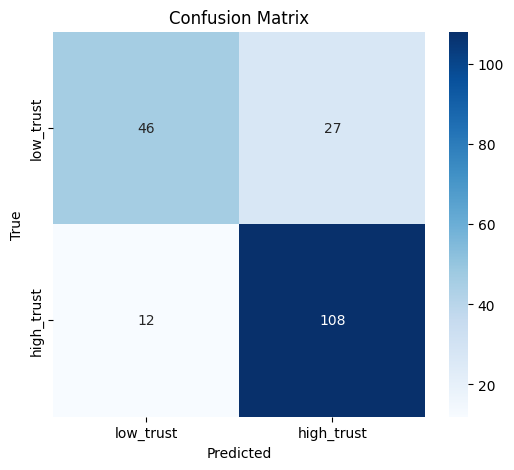

In [ ]:
from sklearn.metrics import confusion_matrix

# Calcular la matriz de confusión
cm = confusion_matrix(y_test_t, y_pred)

# Nombres de las clases
class_names = ['low_trust', 'high_trust']

# Crear el heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from sklearn.metrics import roc_auc_score

y_proba = clf.predict_proba(X_test_t)[:, 1]        
y_true = y_test_t.numpy()

roc_auc = roc_auc_score(y_true, y_proba)
print(f"ROC-AUC: {roc_auc:.3f}")


ROC-AUC: 0.740


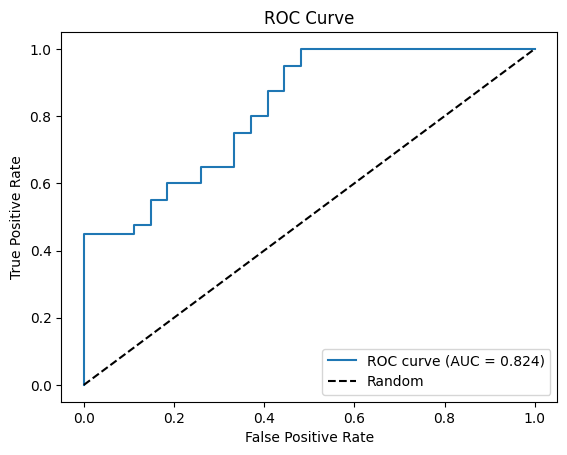

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_true, y_proba)

plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


### RED EEGNeX

In [49]:
from braindecode.models import EEGNeX

In [ ]:
chans = 19     
nb_classes = 2   

model = EEGNeX(
    n_chans= chans,
    n_outputs= nb_classes,
    input_window_seconds= 1,
    n_times = 256,
    drop_prob=0.5,
)

In [64]:
from sklearn.utils.class_weight import compute_class_weight

class_counts = torch.tensor([sum(y_train_t==0), sum(y_train_t==1)], dtype=torch.float32)
class_weights = 1. / class_counts
class_weights = class_weights / class_weights.sum()

criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
# criterion = FocalLoss(alpha=0.6, gamma=1.5, reduction='mean')

In [ ]:
from skorch.callbacks import EarlyStopping, EpochScoring, LRScheduler

f1_macro = EpochScoring(scoring='f1_macro', lower_is_better=False, on_train=False)

early_stopping = EarlyStopping(
    monitor='f1_macro',
    patience=15,
    threshold=0.001,
    lower_is_better=False,
)

valid_loader =TensorDataset(X_valid_t, y_valid_t)

clf = EEGClassifier(
    model,
    criterion= criterion,
    train_split=predefined_split(valid_loader),
    optimizer=torch.optim.Adam,
    optimizer__weight_decay=1e-3,
    optimizer__lr=1e-3,
    batch_size=64,
    # callbacks=[f1_macro, 
    #            early_stopping],
    max_epochs=30,
    device='cpu',
)


In [66]:
# clf.fit(
#     X_train_t, 
#     y_train_t, 
# )

clf.fit(X_train_bal, y_train_bal)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6663       0.4320        0.7040  8.2400
      2        0.5650       0.3964        0.7356  12.3088
      3        0.5037       0.4201        0.7690  18.7902
      4        0.4509       0.5148        0.7667  10.2751
      5        0.3876       0.4852        0.7754  8.1107
      6        0.3519       0.5562        0.7643  8.0560
      7        0.2998       0.5207        0.8420  8.2267
      8        0.3062       0.5385        0.7795  8.2794
      9        0.2654       0.5503        0.8958  21.2696
     10        0.2562       0.5562        0.9686  23.7238
     11        0.2277       0.5621        0.8972  23.9190
     12        0.2030       0.5858        0.8006  23.7331
     13        0.2111       0.5740        0.9167  24.3248
     14        0.2040       0.6036        0.8227  23.8671
     15        0.1884       0.5680        0.8239  24.4996
     16        0.1547

<class 'braindecode.classifier.EEGClassifier'>[initialized](
  module_=================================================================================================================================================================
  Layer (type (var_name):depth-idx)                            Input Shape               Output Shape              Param #                   Kernel Shape
  ================================================================================================================================================================
  EEGNeX (EEGNeX)                                              [1, 19, 256]              [1, 2]                    --                        --
  ├─Sequential (block_1): 1-1                                  [1, 19, 256]              [1, 8, 19, 256]           --                        --
  │    └─Rearrange (0): 2-1                                    [1, 19, 256]              [1, 1, 19, 256]           --                        --
  │    └─Conv2d (1): 2-2                                       [1, 1, 19, 256]           [1, 8, 19, 256]           512                       [1, 64]
  │    └─BatchNorm2d (2): 2-3                                  [1, 8, 19, 256]           [1, 8, 19, 256]           16                        --
  ├─Sequential (block_2): 1-2                                  [1, 8, 19, 256]           [1, 32, 19, 256]          --                        --
  │    └─Conv2d (0): 2-4                                       [1, 8, 19, 256]           [1, 32, 19, 256]          16,384                    [1, 64]
  │    └─BatchNorm2d (1): 2-5                                  [1, 32, 19, 256]          [1, 32, 19, 256]          64                        --
  ├─Sequential (block_3): 1-3                                  [1, 32, 19, 256]          [1, 64, 1, 64]            --                        --
  │    └─ParametrizedConv2dWithConstraint (0): 2-6             [1, 32, 19, 256]          [1, 64, 1, 256]           --                        [19, 1]
  │    │    └─ModuleDict (parametrizations): 3-1               --                        --                        1,216                     --
  │    └─BatchNorm2d (1): 2-7                                  [1, 64, 1, 256]           [1, 64, 1, 256]           128                       --
  │    └─ELU (2): 2-8                                          [1, 64, 1, 256]           [1, 64, 1, 256]           --                        --
  │    └─AvgPool2d (3): 2-9                                    [1, 64, 1, 256]           [1, 64, 1, 64]            --                        [1, 4]
  │    └─Dropout (4): 2-10                                     [1, 64, 1, 64]            [1, 64, 1, 64]            --                        --
  ├─Sequential (block_4): 1-4                                  [1, 64, 1, 64]            [1, 32, 1, 64]            --                        --
  │    └─Conv2d (0): 2-11                                      [1, 64, 1, 64]            [1, 32, 1, 64]            32,768                    [1, 16]
  │    └─BatchNorm2d (1): 2-12                                 [1, 32, 1, 64]            [1, 32, 1, 64]            64                        --
  ├─Sequential (block_5): 1-5                                  [1, 32, 1, 64]            [1, 64]                   --                        --
  │    └─Conv2d (0): 2-13                                      [1, 32, 1, 64]            [1, 8, 1, 64]             4,096                     [1, 16]
  │    └─BatchNorm2d (1): 2-14                                 [1, 8, 1, 64]             [1, 8, 1, 64]             16                        --
  │    └─ELU (2): 2-15                                         [1, 8, 1, 64]             [1, 8, 1, 64]             --                        --
  │    └─AvgPool2d (3): 2-16                                   [1, 8, 1, 64]             [1, 8, 1, 8]              --                        [1, 8]
  │    └─Dropout (4): 2-17                                     [1, 8, 1, 8]              [1, 8, 1, 8]     

In [ ]:
# Obtener predicciones
y_pred = clf.predict(X_test_t)

# Métricas más completas 
from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(y_test_t, y_pred))
print(classification_report(y_test_t, y_pred))

[[19 10]
 [58 95]]
              precision    recall  f1-score   support

           0       0.25      0.66      0.36        29
           1       0.90      0.62      0.74       153

    accuracy                           0.63       182
   macro avg       0.58      0.64      0.55       182
weighted avg       0.80      0.63      0.68       182



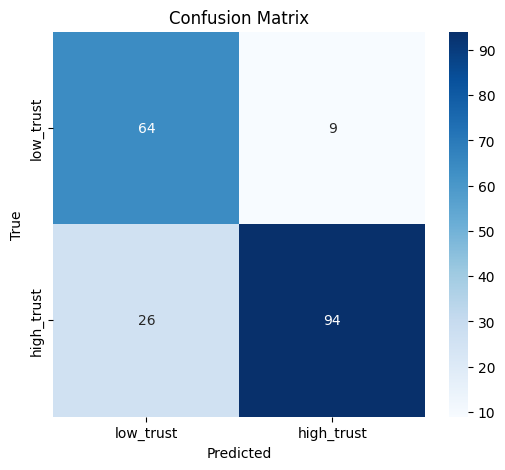

In [ ]:
from sklearn.metrics import confusion_matrix

# Calcular la matriz de confusión
cm = confusion_matrix(y_test_t, y_pred)

# Opcional: nombres de las clases
class_names = ['low_trust', 'high_trust']

# Crear el heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from sklearn.metrics import roc_auc_score

y_proba = clf.predict_proba(X_test_t)[:, 1]  
y_true = y_test_t.numpy()

roc_auc = roc_auc_score(y_true, y_proba)
print(f"ROC-AUC: {roc_auc:.3f}")


ROC-AUC: 0.770


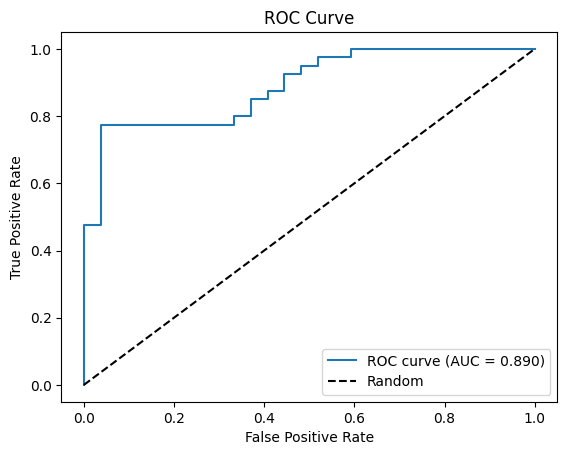

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_true, y_proba)

plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


## Attention Based Net

In [90]:
from braindecode.models import AttentionBaseNet


In [91]:
model = AttentionBaseNet(
    n_chans=19,
    n_outputs=2,
    n_times=256,
    drop_prob_inp=0.2,
    drop_prob_attn= 0.5,

)


In [92]:
from sklearn.utils.class_weight import compute_class_weight

class_counts = torch.tensor([sum(y_train_t==0), sum(y_train_t==1)], dtype=torch.float32)
class_weights = 1. / class_counts
class_weights = class_weights / class_weights.sum()

criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
# criterion = FocalLoss(alpha=0.7, gamma=1.5)

In [93]:
from skorch.callbacks import EarlyStopping, EpochScoring

f1_macro = EpochScoring(scoring='f1_macro', lower_is_better=False, on_train=False)

early_stopping = EarlyStopping(
    monitor='f1_macro',
    patience=15,
    threshold=0.001,
    lower_is_better=False,
)

valid_loader =TensorDataset(X_valid_t, y_valid_t)

clf = EEGClassifier(
    model,
    criterion= criterion,
    train_split=predefined_split(valid_loader),
    optimizer=torch.optim.Adam,
    optimizer__weight_decay=1e-3,
    optimizer__lr=1e-4,
    batch_size=64,
    callbacks=[f1_macro],
    max_epochs=30,
    device='cpu',
)


In [94]:
clf.fit(
    X_train_bal, 
    y_train_bal, 
)

  epoch    f1_macro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.4326        0.7813       0.6686        0.6838  4.5797
      2      0.5860        0.7645       0.6982        0.6758  2.7021
      3      0.5881        0.7534       0.6923        0.6629  2.0278
      4      0.5906        0.7535       0.7041        0.6531  3.1190
      5      0.5860        0.7429       0.6982        0.6486  2.0707
      6      0.6668        0.7275       0.7396        0.6470  2.6857
      7      0.6767        0.7369       0.7456        0.6462  2.2437
      8      0.6514        0.7095       0.7219        0.6471  1.8790
      9      0.6559        0.7029       0.7219        0.6470  1.9681
     10      0.6357        0.7114       0.6982        0.6472  3.2434
     11      0.6349        0.7004       0.6923        0.6471  1.9784
     12      0.6339        0.6841       0.6864        0.6474  2.0498
     13      0.6361        0.6797 

<class 'braindecode.classifier.EEGClassifier'>[initialized](
  module_=================================================================================================================================================================
  Layer (type (var_name):depth-idx)                            Input Shape               Output Shape              Param #                   Kernel Shape
  ================================================================================================================================================================
  AttentionBaseNet (AttentionBaseNet)                          [1, 19, 256]              [1, 2]                    --                        --
  ├─_FeatureExtractor (input_block): 1-1                       [1, 19, 256]              [1, 40, 1, 13]            --                        --
  │    └─Ensure4d (ensure4d): 2-1                              [1, 19, 256]              [1, 19, 256, 1]           --                        --
  │    └─Rearrange (rearrange_input): 2-2                      [1, 19, 256, 1]           [1, 1, 19, 256]           --                        --
  │    └─Conv2d (temporal_conv): 2-3                           [1, 1, 19, 256]           [1, 40, 19, 256]          1,000                     [1, 25]
  │    └─BatchNorm2d (intermediate_bn): 2-4                    [1, 40, 19, 256]          [1, 40, 19, 256]          80                        --
  │    └─Conv2d (spatial_conv): 2-5                            [1, 40, 19, 256]          [1, 40, 1, 256]           760                       [19, 1]
  │    └─BatchNorm2d (bn): 2-6                                 [1, 40, 1, 256]           [1, 40, 1, 256]           80                        --
  │    └─ELU (nonlinearity): 2-7                               [1, 40, 1, 256]           [1, 40, 1, 256]           --                        --
  │    └─AvgPool2d (pool): 2-8                                 [1, 40, 1, 256]           [1, 40, 1, 13]            --                        [1, 75]
  │    └─Dropout (dropout): 2-9                                [1, 40, 1, 13]            [1, 40, 1, 13]            --                        --
  ├─Sequential (channel_expansion): 1-2                        [1, 40, 1, 13]            [1, 16, 1, 13]            --                        --
  │    └─Conv2d (0): 2-10                                      [1, 40, 1, 13]            [1, 16, 1, 13]            640                       [1, 1]
  │    └─BatchNorm2d (1): 2-11                                 [1, 16, 1, 13]            [1, 16, 1, 13]            32                        --
  │    └─ELU (2): 2-12                                         [1, 16, 1, 13]            [1, 16, 1, 13]            --                        --
  ├─_ChannelAttentionBlock (channel_attention_block): 1-3      [1, 16, 1, 13]            [1, 16, 1, 1]             --                        --
  │    └─Sequential (conv): 2-13                               [1, 16, 1, 13]            [1, 16, 1, 13]            --                        --
  │    │    └─Conv2d (0): 3-1                                  [1, 16, 1, 13]            [1, 16, 1, 13]            240                       [1, 15]
  │    │    └─Conv2d (1): 3-2                                  [1, 16, 1, 13]            [1, 16, 1, 13]            256                       [1, 1]
  │    │    └─BatchNorm2d (2): 3-3                             [1, 16, 1, 13]            [1, 16, 1, 13]            32                        --
  │    │    └─ELU (3): 3-4                                     [1, 16, 1, 13]            [1, 16, 1, 13]            --                        --
  │    └─AvgPool2d (pool): 2-14                                [1, 16, 1, 13]            [1, 16, 1, 1]             --                        [1, 8]
  │    └─Dropout (dropout): 2-15                               [1, 16, 1, 1]             [1, 16, 1, 1]             --                        --
  ├─Sequential (final_layer): 1-4                              [1, 16, 1, 1]             [1, 2]            

In [95]:
# Obtener predicciones
y_pred = clf.predict(X_test_t)

# Métricas más completas 
from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(y_test_t, y_pred))
print(classification_report(y_test_t, y_pred))

[[28  1]
 [66 87]]
              precision    recall  f1-score   support

           0       0.30      0.97      0.46        29
           1       0.99      0.57      0.72       153

    accuracy                           0.63       182
   macro avg       0.64      0.77      0.59       182
weighted avg       0.88      0.63      0.68       182



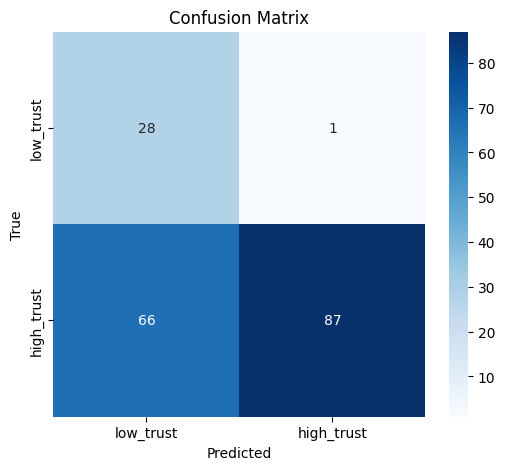

In [96]:
from sklearn.metrics import confusion_matrix

# Calcular la matriz de confusión
cm = confusion_matrix(y_test_t, y_pred)

# Nombres de las clases
class_names = ['low_trust', 'high_trust']

# Crear el heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [97]:
from sklearn.metrics import roc_auc_score

y_proba = clf.predict_proba(X_test_t)[:, 1]  
y_true = y_test_t.numpy()

roc_auc = roc_auc_score(y_true, y_proba)
print(f"ROC-AUC: {roc_auc:.3f}")


ROC-AUC: 0.849


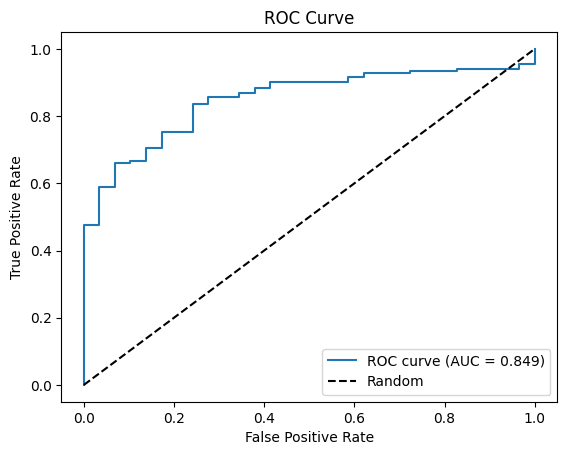

In [98]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_true, y_proba)

plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()
